In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm

# Open the ROOT files
events = uproot.open("/data/mjovanovic/cell_particle_deposit_learning/delta/delta_root_files/delta_full.root" + ":EventTree")
cell_geo_tree = uproot.open("/data/atlas/data/rho_delta/rho_small.root" + ":CellGeo")
for key in events.keys():
    print(key)

# Find the first event with 8 or more truth particles
min_parts = 4
n_truth_part = events["nTruthPart"].array()
first_index = ak.firsts(ak.where(n_truth_part >= min_parts))

if not ak.is_valid(first_index):
    raise ValueError(f"No event with {min_parts} or more truth particles was found.")
print(f"Event {first_index} has {n_truth_part[first_index]} truth particles.")

# Load data for the specific event
event_data = events.arrays(entry_start=first_index[0], entry_stop=first_index[0] + 1)
cell_geo_data = cell_geo_tree.arrays()

# Convert eta, phi to cartesian coordinates
def eta_phi_to_xyz(eta, phi, rPerp):
    theta = 2 * np.arctan(np.exp(-eta))
    return rPerp * np.cos(phi), rPerp * np.sin(phi), rPerp / np.tan(theta)

# Extract cell IDs and geometric data
cell_ids = cell_geo_data["cell_geo_ID"][0]
eta, phi, rPerp = cell_geo_data["cell_geo_eta"][0], cell_geo_data["cell_geo_phi"][0], cell_geo_data["cell_geo_rPerp"][0]

# Convert eta, phi to cartesian coordinates
x, y, z = eta_phi_to_xyz(eta, phi, rPerp)

# Create a dictionary to map cell IDs to their x, y, z coordinates
cell_id_to_xyz = {cell_id: (x_val, y_val, z_val) for cell_id, x_val, y_val, z_val in zip(cell_ids, x, y, z)}

# Process Energy Deposits
# Load energy deposits and cell IDs from the event
hits_truth_id = event_data["cluster_cell_ID"][0]  # Update this if the structure is different
hits_truth_e = event_data["cluster_cell_E"][0] * 1000  # Update and adjust units if necessary

print(f"hits_truth_id: {hits_truth_id}")
print(f"hits_truth_e: {hits_truth_e}")

# Ensure that we're working with flat arrays for zip operation
hits_truth_id_flat = ak.flatten(hits_truth_id)
hits_truth_e_flat = ak.flatten(hits_truth_e)

# Filter cells with no energy deposited and create a dictionary mapping cell IDs to energy deposits
cell_id_to_energy = {cell_id: energy for cell_id, energy in zip(hits_truth_id_flat, hits_truth_e_flat) if energy > 0}
print(f"cell_id_to_energy: {cell_id_to_energy}")

# Determine Color Based on Energy Deposit and Particle Type
# Define color maps for energy deposit and particle types
energy_color_map = plt.get_cmap('viridis')  # Change as needed
particle_color_map = {5: 'yellow', 6: 'blue', '5_and_6': 'green', 'other': 'red'}

# Load particle types (Update this if the structure is different)
if "cluster_cell_hitsTruthIndex" in event_data.fields:
    hits_truth_index = event_data["cluster_cell_hitsTruthIndex"][0][0]
else:
    hits_truth_index = ak.Array([])  # Fallback to an empty array if data is not present

# Assign colors based on energy deposit and particle type
cell_id_to_color_energy = {cell_id: energy_color_map(energy / max(cell_id_to_energy.values())) for cell_id, energy in cell_id_to_energy.items()}
default_color = 'red'  # Default color for undefined particle types
cell_id_to_color_particle = {
    cell_id: particle_color_map.get(particle_type[0], default_color) if len(particle_type) == 1 else particle_color_map.get('5_and_6', default_color)
    for cell_id, particle_type in zip(hits_truth_id_flat, hits_truth_index)
    if cell_id in cell_id_to_energy  # Ensure the cell has an energy deposit
}

# Prepare the data for plotting
# Filtering the coordinates and assigning colors for cells with energy deposits
xyz = np.array([cell_id_to_xyz[cell_id] for cell_id in cell_id_to_energy.keys()])

# Normalize energy values on a log scale for color mapping
energy_norm = LogNorm(vmin=min(cell_id_to_energy.values()), vmax=max(cell_id_to_energy.values()))

# Map energy values to colors using the log scale
colors_energy = [energy_color_map(energy_norm(energy)) for energy in cell_id_to_energy.values()]

colors_particle = np.array([cell_id_to_color_particle.get(cell_id, default_color) for cell_id in cell_id_to_energy.keys()])

# Determine cells without energy deposits
all_cell_ids = set(cell_ids)
cells_with_energy = set(cell_id_to_energy.keys())
cells_without_energy = all_cell_ids - cells_with_energy

# Get the xyz coordinates for cells without energy deposits
xyz_no_energy = np.array([cell_id_to_xyz[cell_id] for cell_id in cells_without_energy])


# Extract energy deposited by particles of indices 1 and 2
hits_truth_index = event_data["cluster_cell_hitsTruthIndex"][0][0]
hits_truth_energy = event_data["cluster_cell_hitsTruthE"][0][0]

# Initialize dictionaries to store energy per cell for particles of index 1 and 2
cell_energy_index_1 = {}
cell_energy_index_2 = {}

# Loop over the cells and their respective energy deposits
for cell_id, energy_list, index_list in zip(hits_truth_id_flat, hits_truth_energy, hits_truth_index):
    for energy, index in zip(energy_list, index_list):
        if index == 1:
            cell_energy_index_1[cell_id] = energy
        elif index == 2:
            cell_energy_index_2[cell_id] = energy

# Ensure that vmin and vmax are valid for LogNorm
vmin_index_1 = min(filter(lambda v: v > 0, cell_energy_index_1.values()))
vmax_index_1 = max(cell_energy_index_1.values())

vmin_index_2 = min(filter(lambda v: v > 0, cell_energy_index_2.values()))
vmax_index_2 = max(cell_energy_index_2.values())

# It's also good to add a small value to vmin to avoid taking log(0) which is undefined
vmin_index_1 = max(vmin_index_1, 1e-3)
vmin_index_2 = max(vmin_index_2, 1e-3)

energy_norm_index_1 = LogNorm(vmin=vmin_index_1, vmax=vmax_index_1)
energy_norm_index_2 = LogNorm(vmin=vmin_index_2, vmax=vmax_index_2)



# Find the global minimum and maximum energy values greater than zero across both indices
min_energy = min(min(filter(lambda v: v > 0, cell_energy_index_1.values()), default=float('inf')),
                 min(filter(lambda v: v > 0, cell_energy_index_2.values()), default=float('inf')))

max_energy = max(max(cell_energy_index_1.values(), default=float('-inf')),
                 max(cell_energy_index_2.values(), default=float('-inf')))

# It's also good to add a small value to min_energy to avoid taking log(0)
min_energy = max(min_energy, 1e-3)

# Calculate common normalization for the first two plots
common_vmin = min(min(cell_energy_index_1.values()), min(cell_energy_index_2.values()))
common_vmax = max(max(cell_energy_index_1.values()), max(cell_energy_index_2.values()))

# Add a small value to common_vmin to avoid log(0)
common_vmin = max(common_vmin, 1e-3)

# Common normalization
common_norm = LogNorm(vmin=common_vmin, vmax=common_vmax)


# Create a single LogNorm instance with the global min and max
shared_energy_norm = LogNorm(vmin=min_energy, vmax=max_energy)

# Map energy values to colors using the shared log scale
colors_energy_index_1 = [energy_color_map(shared_energy_norm(energy)) for energy in cell_energy_index_1.values()]
colors_energy_index_2 = [energy_color_map(shared_energy_norm(energy)) for energy in cell_energy_index_2.values()]


# Find the minimum and maximum energy values that are greater than zero
all_energies = list(cell_energy_index_1.values()) + list(cell_energy_index_2.values())
min_energy = max(min(filter(lambda e: e > 0, all_energies)), 1e-3)
max_energy = max(all_energies)

# Use the same LogNorm for both particle indices
common_norm = LogNorm(vmin=min_energy, vmax=max_energy)

def get_colors_for_existing_indices(cell_energy_dict, xyz_dict, color_map, norm):
    colors = []
    xyz_filtered = []
    for cell_id, energy in cell_energy_dict.items():
        if cell_id in xyz_dict:
            xyz_filtered.append(xyz_dict[cell_id])
            colors.append(color_map(norm(energy)))
    return np.array(xyz_filtered), np.array(colors)

# Get the filtered coordinates and colors for particles with index 1 and 2
xyz_filtered_index_1, colors_energy_index_1 = get_colors_for_existing_indices(
    cell_energy_index_1, cell_id_to_xyz, energy_color_map, energy_norm_index_1
)
xyz_filtered_index_2, colors_energy_index_2 = get_colors_for_existing_indices(
    cell_energy_index_2, cell_id_to_xyz, energy_color_map, energy_norm_index_2
)


# Print final results for inspection
print(f"xyz: {xyz}")
print(f"colors_energy: {colors_energy}")
print(f"colors_particle: {colors_particle}")


runNumber
eventNumber
lumiBlock
coreFlags
mcEventNumber
mcChannelNumber
mcEventWeight
nTruthPart
G4PreCalo_n_EM
G4PreCalo_E_EM
G4PreCalo_n_Had
G4PreCalo_E_Had
truthVertexX
truthVertexY
truthVertexZ
truthPartPdgId
truthPartStatus
truthPartBarcode
truthPartPt
truthPartE
truthPartMass
truthPartEta
truthPartPhi
nTrack
trackPt
trackP
trackMass
trackEta
trackPhi
trackTruthParticleIndex
trackVisibleCalHitCaloEnergy
trackFullCalHitCaloEnergy
trackSubtractedCaloEnergy
trackNumberOfPixelHits
trackNumberOfSCTHits
trackNumberOfPixelDeadSensors
trackNumberOfSCTDeadSensors
trackNumberOfPixelSharedHits
trackNumberOfSCTSharedHits
trackNumberOfPixelHoles
trackNumberOfSCTHoles
trackNumberOfInnermostPixelLayerHits
trackNumberOfNextToInnermostPixelLayerHits
trackExpectInnermostPixelLayerHit
trackExpectNextToInnermostPixelLayerHit
trackNumberOfTRTHits
trackNumberOfTRTOutliers
trackChiSquared
trackNumberDOF
trackD0
trackZ0
trackEta_PreSamplerB
trackPhi_PreSamplerB
trackEta_PreSamplerE
trackPhi_PreSamplerE
t

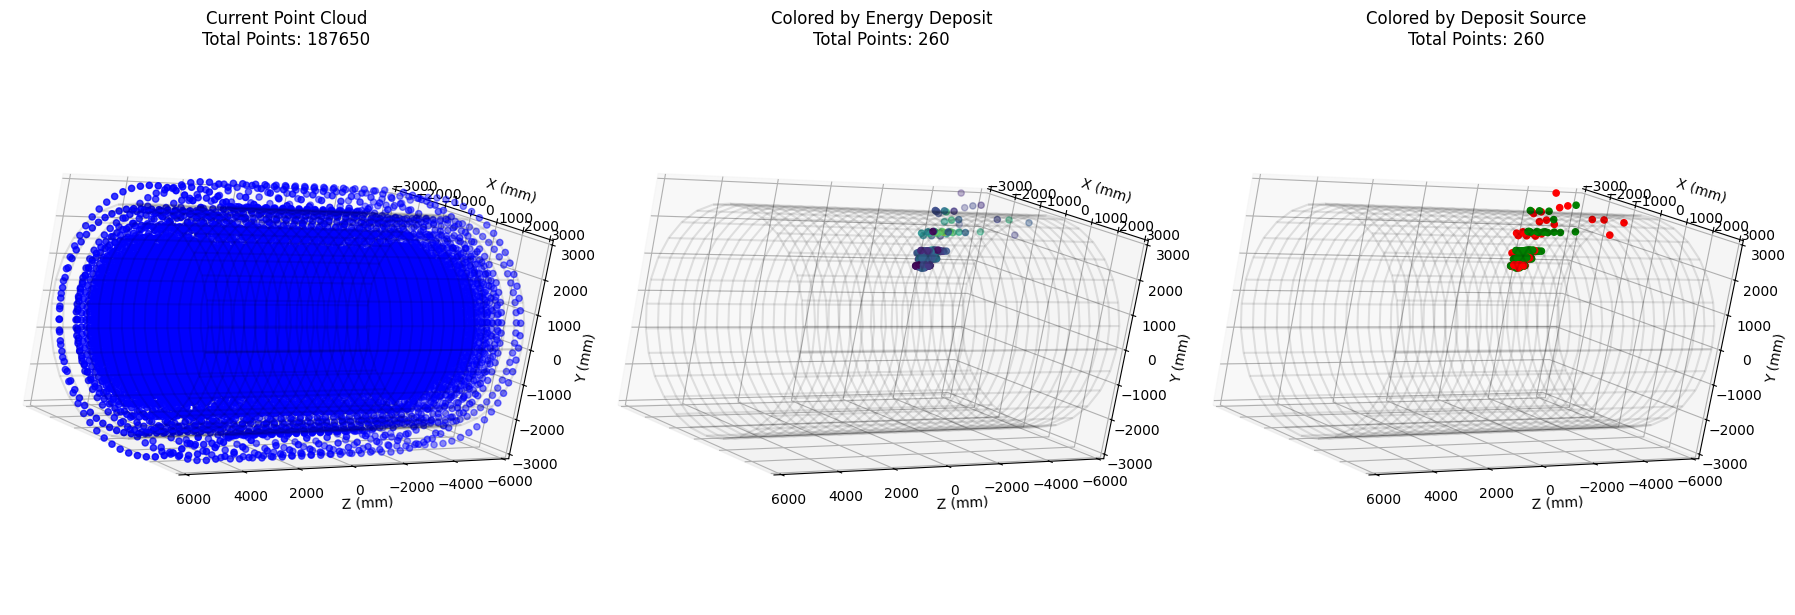

/tmp/ipykernel_3959083/2678197766.py:106: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  scatterA = axA.scatter(
/tmp/ipykernel_3959083/2678197766.py:115: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  scatterB = axB.scatter(


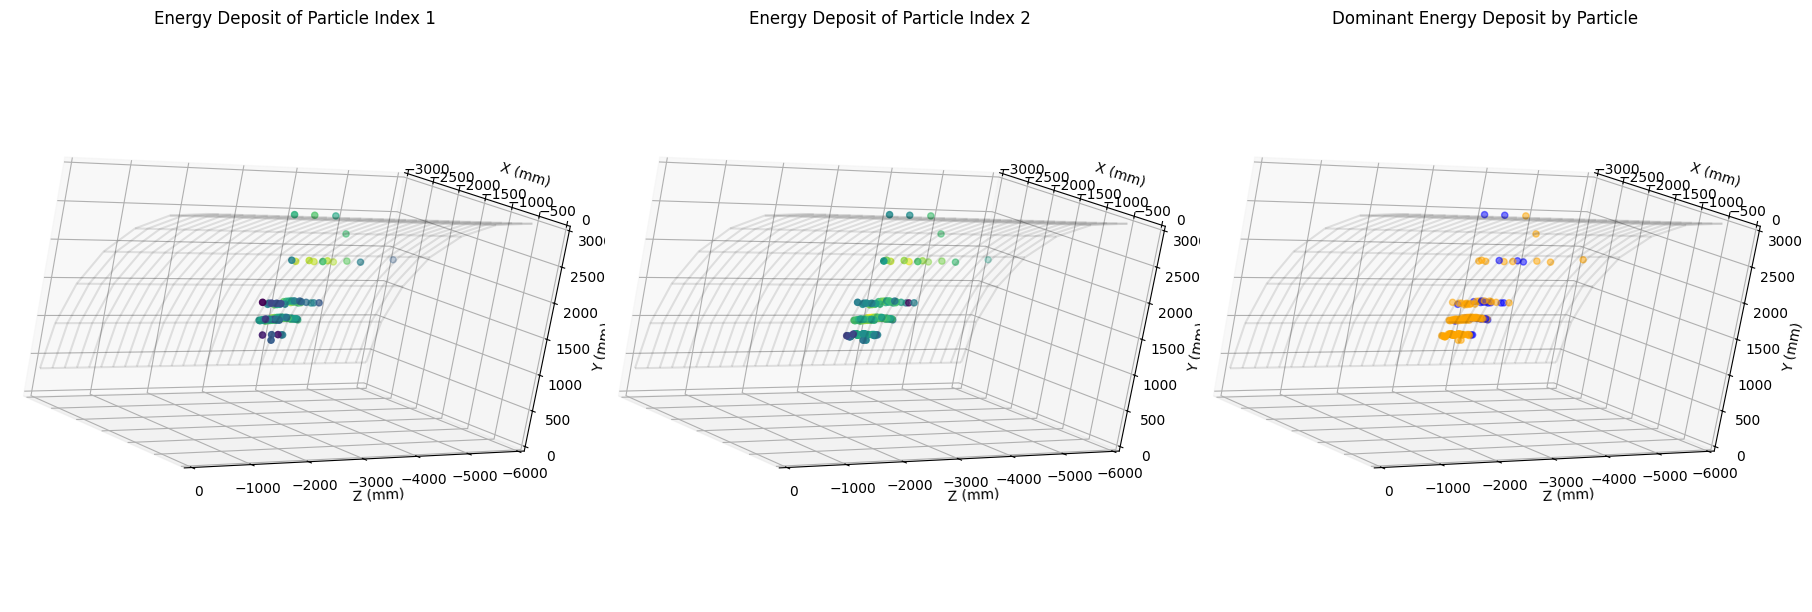

In [4]:
# Titles for the plots
titles = [
    'Current Point Cloud',
    'Colored by Energy Deposit',
    'Colored by Particle Type',
    'Energy Deposit of Particle Index 1',
    'Energy Deposit of Particle Index 2',
    'Dominant Energy Deposit by Particle'
]

# Axis labels
axis_labels = ['X (mm)', 'Y (mm)', 'Z (mm)']


# Define the range for x, y, z axis
x_limits = (-3000, 3000)
y_limits = (-3000, 3000)
z_limits = (-6000, 6000)

x_limits2 = (-3000, 0)
y_limits2 = (0, 3000)
z_limits2 = (-6000, 0)

el = 45
az = 15
ro = 90

# Define cylinder characteristics
r = 3000  # radius
h = 12000  # height
# Cylinder
theta = np.linspace(0, 2 * np.pi, 30)
z_cylinder = np.linspace(-6000, 6000, 30)
theta_grid, z_grid = np.meshgrid(theta, z_cylinder)
x_cylinder = r * np.cos(theta_grid)
y_cylinder = r * np.sin(theta_grid)

z_cylinder_limited = np.linspace(z_limits2[0], z_limits2[1], 30)

# Create a new meshgrid for the limited cylinder
theta_grid_limited, z_grid_limited = np.meshgrid(theta, z_cylinder_limited)
x_cylinder_limited = r * np.cos(theta_grid_limited)
y_cylinder_limited = r * np.sin(theta_grid_limited)

# Apply the masking directly when generating the meshgrid, based on the new limits
x_cylinder_limited = np.where((x_cylinder_limited >= x_limits2[0]) & (x_cylinder_limited <= x_limits2[1]),
                              x_cylinder_limited, np.nan)
y_cylinder_limited = np.where((y_cylinder_limited >= y_limits2[0]) & (y_cylinder_limited <= y_limits2[1]),
                              y_cylinder_limited, np.nan)


# First figure with three plots in a row
fig1 = plt.figure(figsize=(18, 6))  # Increase the width to fit three subplots

# 1. Plot the Current Point Cloud
ax1 = fig1.add_subplot(131, projection='3d')  # Change subplot index to 131
ax1.plot_wireframe(x_cylinder, y_cylinder, z_grid, color='black', alpha=0.1)
ax1.scatter(x, y, z, color='b')
ax1.set_title(f'Current Point Cloud\nTotal Points: {len(x)}')
ax1.set_xlim(x_limits)
ax1.set_ylim(y_limits)
ax1.set_zlim(z_limits)
ax1.set_box_aspect([1,1,2])
ax1.set_xlabel('X (mm)')
ax1.set_ylabel('Y (mm)')
ax1.set_zlabel('Z (mm)')
ax1.view_init(elev=el, azim=az, roll=ro)

# 2. Plot Point Cloud Colored by Total Adjusted Energy Deposit
ax2 = fig1.add_subplot(132, projection='3d')  # Change subplot index to 132
ax2.plot_wireframe(x_cylinder, y_cylinder, z_grid, color='black', alpha=0.1)
scatter = ax2.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=colors_energy)
ax2.set_title(f'Colored by Energy Deposit\nTotal Points: {len(xyz)}')
ax2.set_xlim(x_limits)
ax2.set_ylim(y_limits)
ax2.set_zlim(z_limits)
ax2.set_box_aspect([1,1,2])
ax2.set_xlabel('X (mm)')
ax2.set_ylabel('Y (mm)')
ax2.set_zlabel('Z (mm)')
ax2.view_init(elev=el, azim=az, roll=ro)

# 3. Plot Point Cloud Colored by Particle Type
ax3 = fig1.add_subplot(133, projection='3d')  # Change subplot index to 133
ax3.plot_wireframe(x_cylinder, y_cylinder, z_grid, color='black', alpha=0.1)
scatter = ax3.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=colors_particle, alpha=1.0)
ax3.set_title(f'Colored by Deposit Source\nTotal Points: {len(xyz)}')
ax3.set_xlim(x_limits)
ax3.set_ylim(y_limits)
ax3.set_zlim(z_limits)
ax3.set_box_aspect([1,1,2])
ax3.set_xlabel('X (mm)')
ax3.set_ylabel('Y (mm)')
ax3.set_zlabel('Z (mm)')
ax3.view_init(elev=el, azim=az, roll=ro)

plt.tight_layout()
plt.show()

# Create the second figure with three subplots in a row
fig2 = plt.figure(figsize=(18, 6))


# Plot A: Colored by Energy Deposit of Particle Index 1
axA = fig2.add_subplot(131, projection='3d')
scatterA = axA.scatter(
    xyz_filtered_index_1[:, 0], xyz_filtered_index_1[:, 1], xyz_filtered_index_1[:, 2],
    c=colors_energy_index_1, norm=common_norm
)
axA.set_title(f'Current Point Cloud\nTotal Points: {len(xyz_filtered_index_1)}')


# Plot B: Colored by Energy Deposit of Particle Index 2
axB = fig2.add_subplot(132, projection='3d')
scatterB = axB.scatter(
    xyz_filtered_index_2[:, 0], xyz_filtered_index_2[:, 1], xyz_filtered_index_2[:, 2],
    c=colors_energy_index_2, norm=common_norm
)
axB.set_title(f'Current Point Cloud\nTotal Points: {len(xyz_filtered_index_2)}')

# Plot C: Dominant Energy Deposit by Particle
axC = fig2.add_subplot(133, projection='3d')

# Filter out the cells with energy deposit from either particle index
cells_with_deposit = set(cell_energy_index_1.keys()).union(set(cell_energy_index_2.keys()))

# For each cell with a deposit, determine the dominant particle index
dominant_particle_colors = []
xyz_dominant = []
for cell_id in cells_with_deposit:
    energy_1 = cell_energy_index_1.get(cell_id, 0)
    energy_2 = cell_energy_index_2.get(cell_id, 0)
    if energy_1 > energy_2:
        dominant_particle_colors.append('blue')  # Particle Index 1 is dominant
        xyz_dominant.append(cell_id_to_xyz[cell_id])
    elif energy_2 > energy_1:
        dominant_particle_colors.append('orange')  # Particle Index 2 is dominant
        xyz_dominant.append(cell_id_to_xyz[cell_id])

# Convert to numpy arrays for plotting
xyz_dominant = np.array(xyz_dominant)
scatterC = axC.scatter(
    xyz_dominant[:, 0], xyz_dominant[:, 1], xyz_dominant[:, 2], c=dominant_particle_colors, alpha=0.5
)
axC.set_title('Dominant Energy Deposit by Particle')
axC.set_title(f'Current Point Cloud\nTotal Points: {len(xyz_dominant)}')

# Add titles and axis labels to each subplot in the second figure
for i, ax in enumerate([axA, axB, axC], start=3):
    ax.plot_wireframe(x_cylinder_limited, y_cylinder_limited, z_grid_limited, color='black', alpha=0.1)
    ax.set_title(titles[i])
    ax.set_xlabel(axis_labels[0])
    ax.set_ylabel(axis_labels[1])
    ax.set_zlabel(axis_labels[2])
    ax.set_xlim(x_limits2)
    ax.set_ylim(y_limits2)
    ax.set_zlim(z_limits2)
    ax.set_box_aspect([1,1,2])  # Ensure the aspect ratio matches the data
    ax.view_init(elev=el, azim=az, roll=ro)


plt.tight_layout()
plt.show()
